In [1]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.signal import fftconvolve

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import effectivecurrent2brightness as ec2b
from pulse2percept import utils

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Data
---------
All data was extracted from Jensen et al. (2005), Figure 4: Thresholds for Activation of Rabbit
Retinal Ganglion Cells with Relatively Large, Extracellular Microelectrodes.
Investigative Ophthalmology & Visual Science:46(4).

Axonal data!

In [2]:
# Axonal data extracted from Fig. 4 in Jensen et al. (2005)
jensen2005 = dict()
jensen2005['E125'] = dict()
jensen2005['E500'] = dict()

# Cathodic
jensen2005['E125']['cathodic'] = np.array([0.09790, 3.60377, 0.19721, 1.80616, 0.50172,
                                       0.83488, 0.98945, 0.65090, 1.99315, 0.60031,
                                       4.96424, 0.58921, 9.89445, 0.58921, 20.14408,
                                       0.58555, 51.24806, 0.58555]).reshape((-1, 2))
jensen2005['E125']['cathodic'][:, 0] /= 1000

jensen2005['E500']['cathodic'] = np.array([0.09674, 12.99098, 0.19533, 7.89559, 0.49841,
                                       4.14732, 0.98500, 2.61376, 1.98677, 1.97357,
                                       4.94956, 1.87169, 9.86591, 1.84259, 19.66889,
                                       1.74952, 48.99084, 1.73072]).reshape((-1, 2))
jensen2005['E500']['cathodic'][:, 0] /= 1000



# Anodic
jensen2005['E125']['anodic'] = np.array([0.10000, 8.94028, 0.19931, 5.57116, 0.50172,
                                     3.83516, 1.01067, 3.42874, 2.03590, 3.10379,
                                     5.01719, 3.14266, 10.21449, 3.12316, 20.35897,
                                     3.06540, 51.24806, 3.18202]).reshape((-1, 2))
jensen2005['E125']['anodic'][:, 0] /= 1000

jensen2005['E500']['anodic'] = np.array([0.09849, 26.77548, 0.19485, 13.42013, 0.49741, 6.40109, 0.98211, 4.95176,
                              1.93901, 3.87704, 4.93281, 3.90493, 9.83307, 3.79816, 20.02002, 3.76131,
                              50.94491, 3.56675]).reshape((-1, 2))
jensen2005['E500']['anodic'][:, 0] /= 1000

In [3]:
# Data extracted from Fig. 1
cai2011 = dict()

cai2011['100'] = np.array([0.46257, 0.00105, 0.97908, 0.13688, 1.92488, 1.00413,
                           2.93725, 1.00626, 3.94948, 1.01050, 4.92435, 1.01255,
                           5.93659, 1.01679, 6.92409, 1.01676, 7.94909, 1.01681]).reshape((-1, 2))
cai2011['200'] = np.array([0.47507, 0.00108, 0.95816, 0.07157, 1.95514, 0.71998,
                           2.93725, 1.00626, 3.93698, 1.01047, 4.92448, 1.01045,
                           5.94922, 1.01471, 6.93646, 1.01889, 7.93672, 1.01468]).reshape((-1, 2))
cai2011['300'] = np.array([0.47507, 0.00108, 0.99671, 0.05481, 1.95487, 0.52419,
                           2.93225, 0.88625, 3.93856, 0.98521, 4.94948, 1.01050,
                           5.93672, 1.01468, 6.93672, 1.01468, 7.94909, 1.01681]).reshape((-1, 2))

# Functions
-----------------

Following are all utily funcions used in this script.

In [4]:
class GanglionCell(object):
    def __init__(self, tsample, ca_scale=1.0, ca_tau=0.0191,
                 inl_scale=0, anodic_scale=0,
                 sig_a=3.0, sig_b=8.0):
        ca_scale > 0
        inl_scale > 0
        anodic_scale > 0
        ca_tau > 0
        self.tsample = tsample
        self.ca_scale = ca_scale
        self.ca_tau = ca_tau
        self.inl_scale = inl_scale
        self.anodic_scale = anodic_scale
        self.sig_a = sig_a
        self.sig_b = sig_b

        self.tau_gcl = 0.42 / 1000
        t = np.arange(0, 6 * self.tau_gcl, self.tsample)
        self.gamma_gcl = e2cm.gamma(1, self.tau_gcl, t)
        self.gamma_gcl /= np.trapz(self.gamma_gcl, dx=self.tsample)
        
        self.tau_inl = 18.0 / 1000
        self.delay_inl = 40.0 / 1000
        t = np.arange(0, 10 * self.tau_inl, self.tsample)
        tmp_gamma = e2cm.gamma(2, self.tau_inl, t)
        delay = np.zeros(int(np.round(self.delay_inl / self.tsample)))
        t = np.concatenate((delay, t))
        self.gamma_inl = np.concatenate((delay, tmp_gamma))

        t = np.arange(0, 6 * self.ca_tau, self.tsample)
        self.gamma_ca = e2cm.gamma(1, self.ca_tau, t)
        self.gamma_ca /= np.trapz(self.gamma_ca, dx=self.tsample)

        
    def model_cascade(self, pt, dolayers=None, dojit=True):
        assert pt.tsample == self.tsample
        
        # Calculate charge accumulation on electrode
        self.stim = pt
        # TODO: what if charge accum grows slower for anodic
        self.ca = pt.tsample * fftconvolve(np.abs(pt.data), self.gamma_ca,
                                           mode='full')[:pt.data.size]

        # Calculate impulse responses for GCL and INL layers
        self.r_gcl_lin = utils.sparseconv(self.gamma_gcl, pt.data, mode='full', dojit=True)
        self.r_gcl_lin = pt.tsample * self.r_gcl_lin[:pt.data.size]
        self.r_inl_lin = utils.sparseconv(self.gamma_inl, pt.data, mode='full', dojit=True)
        self.r_inl_lin = pt.tsample * self.r_inl_lin[:pt.data.size]

        # Sum up cathodic vs anodic
        self.r_cath_lin = np.maximum(0, -self.r_gcl_lin) + self.inl_scale * np.maximum(0, -self.r_inl_lin)
        self.r_anod_lin = np.maximum(0, self.r_gcl_lin) + self.inl_scale * np.maximum(0, self.r_inl_lin)
        self.r_lin = self.r_cath_lin + self.anodic_scale * self.r_anod_lin
        
        # Adjust for accumulated charge
        self.r_adj = self.r_lin - self.ca_scale * self.ca
        
        # Feed through logistic activation function
        self.r_rgc = 100.0 / (1.0 + np.exp(-self.sig_a * self.r_adj + self.sig_b))
        
        return utils.TimeSeries(pt.tsample, self.r_rgc)

In [5]:
def fit_amps(x, y, match_y):
    x = np.array(x)
    y = np.array(y)
    # We are given a list of input values `x` and their corresponding output values
    # `y` = f(x). We want to find the `x` value for which f(x) = `match_y`.
    if np.allclose(y.ptp(), 0.0):
        return np.inf

    # Easiest way is to use interp1d as x = f(y)!
    f = interp1d(y.flatten(), x.flatten(), fill_value='extrapolate')
    return np.asscalar(f(match_y))

In [6]:
# Monophasic pulse train
def get_jensen2005_pt(ptype, freq, amp, pdur, stim_dur, tsample=0.005 / 1000):
    assert freq >= 0
    assert amp >= 0  # sign handled by mono pulse
    assert pdur > 0
    assert stim_dur >= 0
    
    delay_dur = 20.0 / 1000
    
    stim_size = int(round(stim_dur / tsample))
    if np.isclose(amp, 0.0) or np.isclose(freq, 0.0):
        return utils.TimeSeries(tsample, np.zeros(stim_size))
    
    envelope_dur = 1.0 / float(freq)
    assert envelope_dur > delay_dur
    pulse_train = np.array([])
    for j in range(int(np.ceil(stim_dur * freq))):
        # A single mono pulse
        pulse = e2cm.get_monophasic_pulse(ptype, pdur, tsample, delay_dur, envelope_dur) * amp
        pulse_train = np.concatenate((pulse_train, pulse), axis=0)
    pulse_train = pulse_train[:stim_size]
    
    return utils.TimeSeries(tsample, pulse_train)

# Run model
-----------------

In [7]:
def run_jensen2005_fig4(model, ptype, pdurs, amps, verbose=False):
    stim_dur = 500.0 / 1000
    stim_freq = 2.0
    
    gcr = model['gcr']
    tsample = gcr.tsample
    
    fig4 = dict()
    fig4['pulse_durs'] = pdurs
    
    resp = []
    for pd, amp in zip(pdurs, amps):
        stim = get_jensen2005_pt(ptype, stim_freq, amp, pd, stim_dur, tsample)
        mov = gcr.model_cascade(stim)
        resp.append(mov.data.max())

    fig4['resp'] = np.array(resp)
    return fig4

In [8]:
def run_cai2011_exp1(model, amp_th, freqs):
    pdur = 0.2 / 1000
    
    gcr = model['gcr']
    tsample = gcr.tsample

    exp1 = dict()
    exp1['freqs'] = freqs
    exp1['amp_th'] = amp_th
    exp1['amps'] = np.arange(9) * amp_th
    for freq in freqs:
        cond = str(freq)
        exp1[cond] = dict()
        
        idur = 0.5 / freq
        
        resp = []
        for amp in exp1['amps']:
            stim = e2cm.Psycho2Pulsetrain(tsample, freq=freq, amp=amp, dur=0.5,
                                          pulse_dur=pdur, interphase_dur=idur,
                                          pulsetype='cathodicfirst',
                                          delay=0.0 / 1000)
            mov = gcr.model_cascade(stim)
            resp.append(np.squeeze(mov.data.max()))

        exp1[cond]['resp'] = np.array(resp)
        exp1[cond]['norm_resp'] = (np.array(resp) + np.finfo(float).eps) / 100.0
        
    return exp1

In [9]:
def mse_jensen2005_fig4(x, jensen2005):
    mse = 0
    for diam in [125.0, 500.0]:
        ename = 'E%.0f' % diam
        for ptype in ['cathodic', 'anodic']:
            model = get_model(x, diam)
            fig4 = run_jensen2005_fig4(model, ptype, jensen2005[ename][ptype][:, 0],
                                      jensen2005[ename][ptype][:, 1])
            mse += np.sum((fig4['resp'] - 1.0) ** 2)
            if fig4['resp'].max() < 0.5 or np.sum(fig4['resp']) < fig4['resp'].size / 2.0:
                # prevent from zeroing out
                mse += 1.0 / (np.sum(fig4['resp']) + np.finfo(float).eps)
#     print('%s: %.9f' % (str([('%.9f' % xx) for xx in x]), mse))
    return mse

In [10]:
def mse_cai2011_exp1(x, cai2011, freqs):
    model = get_model(x, 40.0)
    exp1 = run_cai2011_exp1(model, 20.0, freqs)
    
    mse = 0
    for freq in exp1['freqs']:
        cond = str(freq)
        
        mse += np.mean(np.abs(exp1[cond]['norm_resp'] - cai2011[cond][:, 1]) ** 2)
    
#     print('%s: %.7f' % (str([('%.7f' % xx) for xx in x]), mse))
    return mse

In [11]:
def mse_all(x, jensen2005, cai2011):
    mse = 0
    
    mse += mse_jensen2005_fig4(x, jensen2005)
    mse += mse_cai2011_exp1(x, cai2011, [100, 200, 300])
    
    print('%s: %.9f' % (str([('%.9f' % xx) for xx in x]), mse))
    return mse

In [12]:
def get_model(x, diam):
    tsample = 0.005 / 1000

    [ca_scale, anodic_scale, sig_a, sig_b] = x
    model = dict()
    
    # Stimulating electrode remained 25um above the inner limiting membrane
    model['implant'] = e2cm.ElectrodeArray('epiretinal', diam / 2, -500, -500, 0.0)

    r_sampling = 100
    axon_lambda = 2 
    model['retina'] = e2cm.Retina(sampling=r_sampling, axon_lambda=axon_lambda, rot=0,
                                  xlo=model['implant'][0].x_center,
                                  xhi=model['implant'][0].x_center,
                                  ylo=model['implant'][0].y_center,
                                  yhi=model['implant'][0].y_center)

    model['gcr'] = GanglionCell(tsample, ca_scale=ca_scale, inl_scale=0,
                                anodic_scale=anodic_scale, sig_a=sig_a, sig_b=sig_b)
    return model

In [13]:
# res = minimize(mse_all, [10.0, 0.522, 0.1, 4.666], args=(jensen2005, cai2011),
#                method='L-BFGS-B', bounds=[(0.01, 20.0), (0.01, 10.0),
#                                           (0.01, 100.0), (0.01, 50.0)])

# Results
---------

In [15]:
# ['0.991156466', '0.496271332', '2.560214315', '10.932716258']: 48.010113190
# res.x

In [16]:
def run_fig4_find_amp(model, ptype, amp_th, pulse_durs, verbose=False):
    stim_dur = 500.0 / 1000
    stim_freq = 2.0
    
    gcr = model['gcr']
    tsample = gcr.tsample
    
    fig4 = dict()
    fig4['pulse_durs'] = pulse_durs
    
    # We need to define some activity value that corresponds to threshold activity.
    # We do this by executing the model at the first data point of the Jensen paper.
    # Whatever activity is produced by these parameters, we'll take as threshold
    # activity, and will try to find the matching current for all subsequent data points
    stim = get_jensen2005_pt(ptype, stim_freq, amp_th, pulse_durs[0], stim_dur, tsample)
    mov = gcr.model_cascade(stim)
    act_match = mov.data.max()
    amp_in = np.array([0.05, 0.1, 0.5, 1.0])
    fig4['amp_in'] = amp_in

    if verbose:
        print('- Threshold=%f' %  act_match)

    amp_match = []
    for pd in pulse_durs:
        cond = '%.3f' % pd
        fig4[cond] = dict()

        if verbose:
            print('- Processing pulse dur %f' % pd)
        act_out = []
        for amp in amp_in:
            stim = get_jensen2005_pt(ptype, stim_freq, amp, pd, stim_dur, tsample)
            idx_onset = stim.data.nonzero()[0][0]
            mov = gcr.model_cascade(stim)
            act_out.append(mov.data.max())
        fig4[cond]['act_out'] = act_out
        amp_match.append(fit_amps(amp_in, act_out, act_match))
        
    fig4['amp_match'] = np.array(amp_match)
    return fig4

In [17]:
xx = np.array([ 0.01      ,  0.38265105,  0.16493721,  4.83909986])

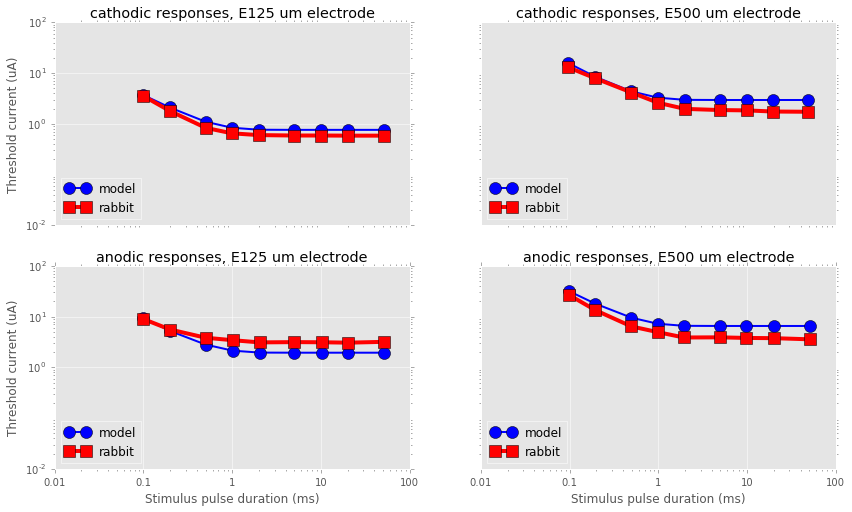

In [19]:
plt.figure(figsize=(14, 8))

subplot = 1
for ptype in ['cathodic', 'anodic']:
    for diam in [125, 500]:
        ename = 'E%.0f' % diam
        model = get_model(xx, diam)
        plt.subplot(2, 2, subplot)
        
        fig4 = run_fig4_find_amp(model, ptype, jensen2005[ename][ptype][0, 1],
                                jensen2005[ename][ptype][:, 0])
        plt.loglog(jensen2005[ename][ptype][:, 0], fig4['amp_match'],
                   'o-b', linewidth=2, markersize=12, label='model')
        plt.loglog(jensen2005[ename][ptype][:, 0], jensen2005[ename][ptype][:, 1],
                   's-r', linewidth=4, markersize=12, label='rabbit')
        
        plt.title('%s responses, %s um electrode' % (ptype, ename))
        plt.legend(loc='lower left')
        plt.xlim(0.01 / 1000, 100.0 / 1000)
        plt.ylim(0.01, 100)
        if subplot > 2:
            plt.xticks(np.array([0.01, 0.1, 1, 10, 100]) / 1000, [0.01, 0.1, 1, 10, 100])
            plt.xlabel('Stimulus pulse duration (ms)')
        else:
            plt.xticks([])
        if (subplot - 1) % 2 == 0:
            plt.yticks([0.01, 1, 10, 100])
            plt.ylabel('Threshold current (uA)')
        else:
            plt.yticks([])
        
        subplot += 1
plt.savefig('cathodic_anodic.png')